In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
import os
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,Sequence
import math

C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.listdir("./input")

['100K_Train', 'avito-demand-prediction', 'fasttext-russian-2m']

In [2]:
trainDF = pd.read_csv("./input/avito-demand-prediction/train.csv")
testDF = pd.read_csv("./input/avito-demand-prediction/test.csv")

#trainDF.head()
testDF.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


In [3]:
def percentileOneHot(dealProb,nBuckets=10):
    val = math.floor((dealProb*nBuckets))
    if dealProb == 1: 
        val = nBuckets-1
        
    return val,to_categorical(val , num_classes=nBuckets)

featureColumns = ["description","price","category_name"]
trainDF = trainDF[featureColumns+["deal_probability"]].dropna(axis=0, how='any')
testDF = testDF[["item_id"]+featureColumns].fillna(0)

max_features = 20000
maxlen = 200

tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(trainDF["description"])

trainDF["description"] = tokenizer.texts_to_sequences(trainDF["description"])
testDF["description"]  = tokenizer.texts_to_sequences(testDF["description"])

train_x = pad_sequences(trainDF["description"], maxlen=maxlen)
test_x = pad_sequences(testDF["description"], maxlen=maxlen)

trainDF['category_name'], mapping_index_category = pd.Series(trainDF['category_name']).factorize()
reverseCatMap = {mapping_index_category[i]: i for i in range(0, len(mapping_index_category))}
testDF['category_name'] = testDF['category_name'].map(reverseCatMap)

percentileRes = trainDF["deal_probability"].map(percentileOneHot) 
trainDF = trainDF.assign(percentileClassID = percentileRes.apply(lambda x: x[0]), percentileClass = percentileRes.apply(lambda x: x[1]))

In [7]:
class EvenClassDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, categoricalColumn, batch_size=10):
        'Initialization'
        self.df = df
        self.batch_size = batch_size
        self.classes = list(np.sort(self.df[categoricalColumn].unique()))
        self.categories = list(map(lambda x: self.df[self.df[categoricalColumn] == x]
                                   .assign(dTok = list(self.descriptionDF[self.df[categoricalColumn] == x])),self.classes))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return None

    def __getitem__(self, index):
        'Generate one batch of data'
        resultsX  = []
        resultsY  = []
        dealProbs = []
        classIdx  = 0
        
        for cat in self.categories:
            sample = cat.sample(self.batch_size)
            resultsX.append(np.vstack(sample["dTok"]))
            resultsY.append(np.vstack( [to_categorical(self.classes[classIdx] , num_classes=len(self.classes))]*self.batch_size))
            dealProbs.append(np.vstack(sample["deal_probability"]))
            classIdx += 1
            
        X = np.vstack(resultsX)
        y = [np.vstack(resultsY),np.vstack(dealProbs)]
        return X, y
    
evenCat = EvenClassDataGenerator(trainDF,train_x,"percentileClassID",60)

In [7]:
x,y = evenCat[0:1]

In [17]:
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Concatenate, GlobalMaxPool1D
from keras.models import Model

embed_size = 128
maxlen = 200
max_features = 20000

# Description 
inp = Input(shape=(maxlen, ))

x = Embedding(max_features, embed_size)(inp)

x = LSTM(200, return_sequences=True,name='lstm_layer1')(x)
x = GlobalMaxPool1D()(x)

x = Dense(1000, activation="sigmoid")(x)
x = Dense(1000, activation="sigmoid")(x)
x = Dense(1000, activation="sigmoid")(x)

o1 = Dense(10, activation="softmax",name='percentile_out')(x)
o2 = Dense(1, activation="softplus", name='dealprob_out')(x)

model = Model(inp,[o1,o2])
model.compile(loss={'percentile_out': 'categorical_crossentropy', 'dealprob_out': 'binary_crossentropy'},
              loss_weights={'percentile_out': .3, 'dealprob_out': .7},
              optimizer='adam',metrics={'percentile_out': 'categorical_accuracy', 'dealprob_out':'accuracy'})

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 128)     2560000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_layer1 (LSTM)              (None, 200, 200)     263200      embedding_7[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_7 (GlobalM (None, 200)          0           lstm_layer1[0][0]                
__________________________________________________________________________________________________
dense_19 (

In [18]:
model.fit_generator(evenCat,steps_per_epoch=500,epochs=120,verbose=1)

Epoch 1/120
103/500 [=====>........................] - ETA: 1:59 - loss: 6.3125 - percentile_out_loss: 2.3135 - dealprob_out_loss: 8.0264 - percentile_out_categorical_accuracy: 0.1078 - dealprob_out_acc: 8.0906e-04

KeyboardInterrupt: 

In [12]:
#model.save("evenClasses5_16_18_90Per.h5")

In [166]:
np.argmax(modelTrainPred,axis=1)

array([1, 0, 4, ..., 6, 0, 0], dtype=int64)

C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


65

In [169]:
trainDF["percentileClass"].shape

(1305348,)

In [173]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(np.argmax(modelTrainPred,axis=1),trainDF["percentileClassID"]))

,0,1,2,3,4,5,6,7,8,9
0,592905,8385,3366,517,105,25,41,1049,5406,0
1,136698,85279,1114,383,80,10,18,605,1775,1
2,57283,1729,61237,282,91,25,21,495,849,17
3,19890,1110,624,32232,81,12,11,483,697,1
4,7794,581,480,226,16969,22,20,426,266,3
5,2292,177,153,84,55,7243,21,172,137,8
6,2778,188,180,46,54,2,7510,128,182,11
7,35580,1404,801,366,126,22,27,56717,407,5
8,65892,1383,682,195,59,5,10,350,69837,0
9,894,42,135,18,42,33,17,73,48,7038


In [16]:
#trainPriceDescs = test_x[~testDF["price"].isnull() & ~testDF["description"].isnull()]
#modelPredDesc = model.predict(test_x)

In [110]:
modelPred = model.predict(test_x)

In [ ]:
#modelPred[testDF["price"] == 0] = trainDF[trainDF["price"] == 0]["deal_probability"].mean()

In [82]:
maxPreds = np.argmax(modelPred,axis=1)
scaledPreds = maxPreds/10

In [83]:
data_to_submit = pd.DataFrame.from_items([
    ('item_id',testDF["item_id"]),
    ('deal_probability', pd.Series(scaledPreds))])

data_to_submit.to_csv('csv_to_submit_5_17_2018_2.csv', index = False)

#data_to_submit.head()

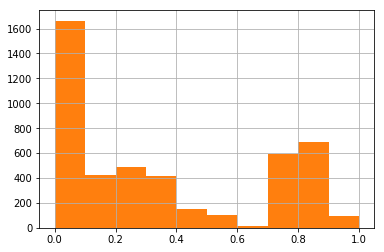

In [69]:
trainDF[trainDF["price"] == 0]["deal_probability"].hist()
plt.show()

In [66]:
(testDF["price"] == 0).count()

508438

In [93]:
 np.argmax(model.predict(train_x[10:20]),axis=1)

array([5, 0, 1, 1, 0, 3, 1, 1, 1, 3], dtype=int64)

In [160]:
trainDF[20:30]["deal_probability"]

21    0.00000
22    0.10334
23    0.00000
25    0.10796
26    0.00000
27    0.00000
28    0.00000
29    0.00000
31    0.78501
32    0.00000
Name: deal_probability, dtype: float64

In [161]:
pd.DataFrame(model.predict(train_x[20:30]).round(3))

,0,1,2,3,4,5,6,7,8,9
0,0.277,0.722,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
1,0.128,0.833,0.001,0.001,0.000,0.000,0.000,0.038,0.000,0.0
2,0.600,0.359,0.023,0.000,0.000,0.000,0.000,0.000,0.018,0.0
3,0.012,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0
4,0.254,0.273,0.151,0.014,0.002,0.001,0.001,0.026,0.279,0.0
5,0.364,0.131,0.294,0.002,0.001,0.000,0.006,0.001,0.201,0.0
6,0.767,0.220,0.007,0.001,0.000,0.000,0.000,0.000,0.006,0.0
7,0.329,0.104,0.161,0.174,0.058,0.000,0.000,0.001,0.173,0.0
8,0.151,0.027,0.000,0.000,0.017,0.000,0.000,0.734,0.072,0.0
9,0.060,0.006,0.928,0.006,0.000,0.000,0.000,0.000,0.000,0.0


In [99]:
(testDF["price"] == 0).sum()

1924

In [102]:
testDF.shape

(508438, 17)

In [106]:
(testDF["description"] == "").sum()

0

In [109]:
testDF["description"].isnull().sum()

0

In [130]:
inp = Input(shape=(10, ))

x = Dense(1000,activation="sigmoid")(inp)
x = Dense(1, activation="sigmoid")(x)

model2 = Model(inp,x)
model2.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              11000     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 1001      
Total params: 12,001
Trainable params: 12,001
Non-trainable params: 0
_________________________________________________________________


In [132]:
model2.fit(modelTrainPred,trainDF["deal_probability"],batch_size=200,epochs=10,shuffle=True)

Epoch 1/10
1305348/1305348 [==============================] - 19s 14us/step - loss: 0.2666 - acc: 0.6391
Epoch 2/10
1305348/1305348 [==============================] - 19s 14us/step - loss: 0.2642 - acc: 0.6388
Epoch 3/10
1305348/1305348 [==============================] - 19s 14us/step - loss: 0.2635 - acc: 0.6389
Epoch 4/10
1305348/1305348 [==============================] - 19s 14us/step - loss: 0.2618 - acc: 0.6394
Epoch 5/10
1305348/1305348 [==============================] - 19s 15us/step - loss: 0.2606 - acc: 0.6398
Epoch 6/10
1305348/1305348 [==============================] - 19s 14us/step - loss: 0.2601 - acc: 0.6401
Epoch 7/10
1305348/1305348 [==============================] - 18s 14us/step - loss: 0.2598 - acc: 0.6403
Epoch 8/10
1305348/1305348 [==============================] - 19s 14us/step - loss: 0.2596 - acc: 0.6408
Epoch 9/10
1305348/1305348 [==============================] - 19s 14us/step - loss: 0.2593 - acc: 0.6411
Epoch 10/10
1305348/1305348 [==========================

In [157]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Concatenate

inp1 = Input(shape=(10, ))

x = Dense(100,activation="sigmoid")(inp1)

inp2 = Input(shape=(1, ))
y = Dense(100,activation="sigmoid")(inp2)

inp3 = Input(shape=(1, ))
z = Dense(100,activation="sigmoid")(inp3)


x = Concatenate(axis=-1)([x,y,z])
x = Dense(1000,activation="sigmoid")(x)
x = Dense(1000,activation="sigmoid")(x)
x = Dense(1000,activation="sigmoid")(x)
x = Dense(1000,activation="sigmoid")(x)

x = Dense(1, activation="sigmoid")(x)

model2 = Model([inp1,inp2,inp3],x)
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 100)          1100        input_30[0][0]                   
__________________________________________________________________________________________________
dense_58 (

In [158]:
model2.fit([modelTrainPred,trainDF['category_name'],trainDF['price']],trainDF["deal_probability"],batch_size=200,epochs=10,shuffle=True)

Epoch 1/10
1305348/1305348 [==============================] - 48s 36us/step - loss: 0.2703 - acc: 0.6402
Epoch 2/10
 380600/1305348 [=======>......................] - ETA: 33s - loss: 0.2618 - acc: 0.6404

KeyboardInterrupt: 

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Concatenate

inp1 = Input(shape=(10, ))

x = Dense(100,activation="sigmoid")(inp1)

inp2 = Input(shape=(1, ))
y = Dense(100,activation="sigmoid")(inp2)

inp3 = Input(shape=(1, ))
z = Dense(100,activation="sigmoid")(inp3)


x = Concatenate(axis=-1)([x,y,z])
x = Dense(1000,activation="sigmoid")(x)
x = Dense(1000,activation="sigmoid")(x)
x = Dense(1000,activation="sigmoid")(x)
x = Dense(1000,activation="sigmoid")(x)

x = Dense(1, activation="sigmoid")(x)

model2 = Model([inp1,inp2,inp3],x)
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

In [117]:
modelTrainPred = model.predict(train_x)

(1305348, 10)

In [121]:
trainDF.shape

(1305348, 6)